In [57]:
import io
import json
import numpy as np
from six.moves import urllib
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split
import matplotlib.pyplot as plt
#from sklearn.metrics import mean_absolute_percentage_error

In [95]:
class COVIDIndiaDatasetLoader(object):
    """A dataset of county level chicken pox cases in Hungary between 2004
    and 2014. We made it public during the development of PyTorch Geometric
    Temporal. The underlying graph is static - vertices are counties and 
    edges are neighbourhoods. Vertex features are lagged weekly counts of the 
    chickenpox cases (we included 4 lags). The target is the weekly number of 
    cases for the upcoming week (signed integers). Our dataset consist of more
    than 500 snapshots (weeks). 
    """
    def __init__(self):
        self._read_web_data()


    def _read_web_data(self):
        self._dataset = json.load(open("./processed_data.json",  "r"))


    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T


    def _get_edge_weights(self):
        self._edge_weights = np.ones(self._edges.shape[1])


    def _get_targets_and_features(self):
        stacked_target = np.array(self._dataset["FX"])
        self.features = [stacked_target[i:i+self.lags,:].T for i in range(stacked_target.shape[0]-self.lags)]
        self.targets = [stacked_target[i+self.lags,:].T for i in range(stacked_target.shape[0]-self.lags)]


    def get_dataset(self, lags: int=4) -> StaticGraphTemporalSignal:
        """Returning the Chickenpox Hungary data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags. 
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Chickenpox Hungary dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(self._edges, self._edge_weights, self.features, self.targets)
        return dataset

In [96]:
dataloader = COVIDIndiaDatasetLoader()

In [97]:
dataset = dataloader.get_dataset(lags=21)

In [98]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [99]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 16, 1)
        self.linear = torch.nn.Linear(16, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.leaky_relu(h)
        h = self.linear(h)
        return h

In [100]:
from tqdm import tqdm

model = RecurrentGCN(node_features=21)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(100)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.03it/s]


In [110]:
model.eval()
cost = 0
preds = []
ys = []
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y) ** 2)
    preds.append((y_hat.detach().numpy().reshape(1, 34)))
    ys.append((snapshot.y.detach().numpy().reshape(1, 34)))
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 180209.1562


In [111]:
import joblib 
scaler = joblib.load('minmaxscaler.pkl') 

In [112]:
np.array(preds).shape

(28, 1, 34)

In [113]:
preds = np.array(preds).reshape(28, 34)
ys = np.array(ys).reshape(28, 34)

In [114]:
preds[:, 1]

array([-9.078642  ,  9.868058  ,  9.868058  , -1.5919108 , -1.9012818 ,
       -6.924945  , -7.789712  , -9.066868  ,  9.878572  ,  9.868058  ,
        4.965765  ,  0.23815748, -8.9874    , -9.066868  , -9.0903    ,
        9.868058  ,  9.880953  ,  7.467043  ,  0.21543182, -6.7243624 ,
       -9.066868  , -9.078495  ,  9.868058  ,  9.891858  ,  4.744814  ,
        2.3801625 , -6.6174145 , -9.066868  ], dtype=float32)

In [115]:
ys[:, 1]

array([ -95.,   32.,   15.,  110.,    9.,  -61., -105.,  -70.,  182.,
          2.,  -14.,  101.,  -53.,  -44., -213.,   80.,   58.,   -2.,
         78.,  -53.,  -41., -101.,   84.,   -2.,  130.,  -38.,  -43.,
         30.], dtype=float32)

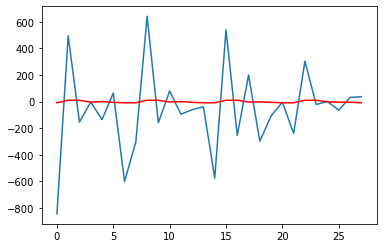

In [116]:
plt.plot(ys[:,20])
plt.plot(preds[:,20], c='r')